In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm

## Load results of MC simulation

In [2]:
ml_models = {
    'eln': 'Elastic net',
    'svm': 'SVM',
    #'rf': 'Random forest',
    'xgb': 'XGBoost',
    'mlp': 'MLP',
}

color_mapper = {
    'eln': 'tab:red',
    'svm': 'tab:green',
    #'rf': 'tab:olive', 
    'xgb': 'tab:orange',
    'mlp': 'tab:purple',
}

In [3]:
results_ate = {}

for ml_key, ml_name in ml_models.items():
    with open(f'{ml_name}/results_ate_{ml_key}.pkl', 'rb') as pickle_file:
        results_ate[ml_key] = pickle.load(pickle_file)

In [4]:
sample_sizes = list(results_ate['eln'].keys())

## Approximation error of nuisance estimators

In [5]:
nuisance_names = [r'$\hat{g}_0(0)$', r'$\hat{g}_0(1)$', r'$\hat{m}_0$']

In [6]:
rmses = [[np.mean(results_ate[ml_key][N][-1][:, :3], axis=0) for ml_key in ml_models] for N in sample_sizes]
rmses = np.array(rmses)

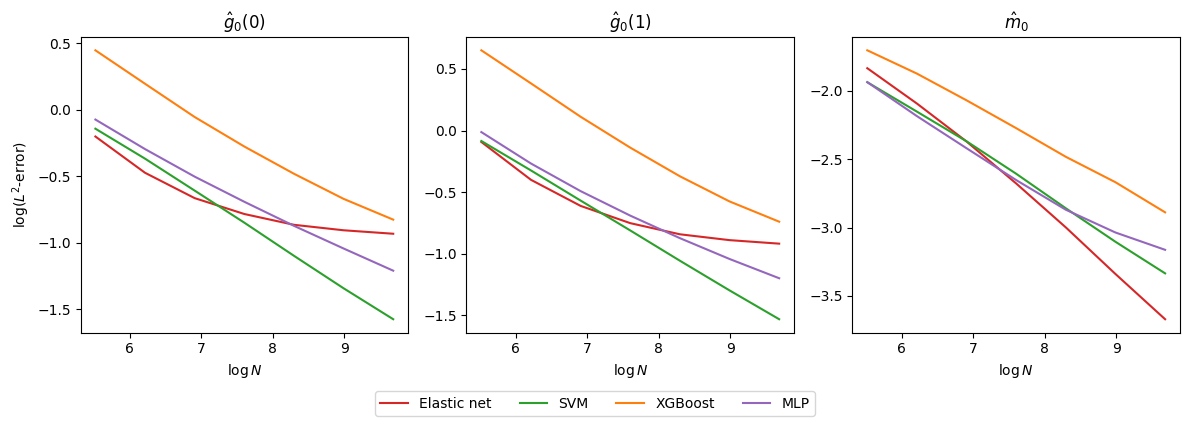

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i, nuisance_name in enumerate(nuisance_names):
    ax = axes[i] 
    ax.set_title(nuisance_name)
    
    for k, (ml_key, ml_name) in enumerate(ml_models.items()):
        ax.plot(np.log(sample_sizes), np.log(rmses[:, k, i]), color=color_mapper[ml_key], label=ml_name)
        ax.set_xlabel(r'$\log N$')
        
    if i == 0:
        ax.set_ylabel(r'$\log(L^2\text{-error})$')
        ax.set_yticks([-1.5, -1.0, -0.5, 0.0, 0.5])
    if i == 2:
        ax.set_yticks([-3.5, -3.0, -2.5, -2.0])
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(ml_models), bbox_to_anchor=(0.5, -0.07))

fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_ate_no_clipping/ml_conv_1.{fmt}', dpi=300, bbox_inches='tight')

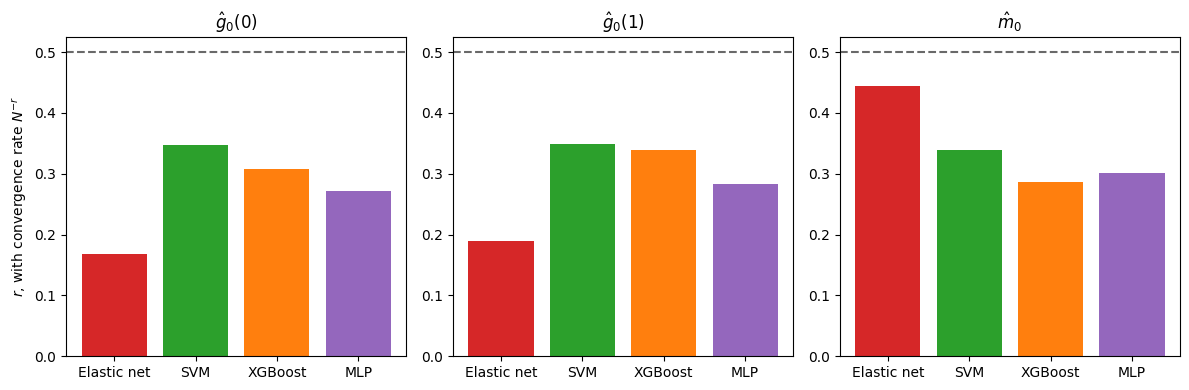

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i, nuisance_name in enumerate(nuisance_names):
    ax = axes[i] 
    ax.set_title(nuisance_name)

    slopes = np.polyfit(np.log(sample_sizes), np.log(rmses[..., i]), 1)[0, :]
    ax.bar(ml_models.values(), -slopes, color=color_mapper.values())
    ax.axhline(y=0.5, color='dimgrey', linestyle='--')
        
    if i == 0:
        ax.set_ylabel(r'$r$, with convergence rate $N^{-r}$')

fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_ate_no_clipping/ml_conv_2.{fmt}', dpi=300, bbox_inches='tight')

## Asymptotics of DML estimator using different ML methods

In [9]:
theta_0 = 0.5   # true ATE

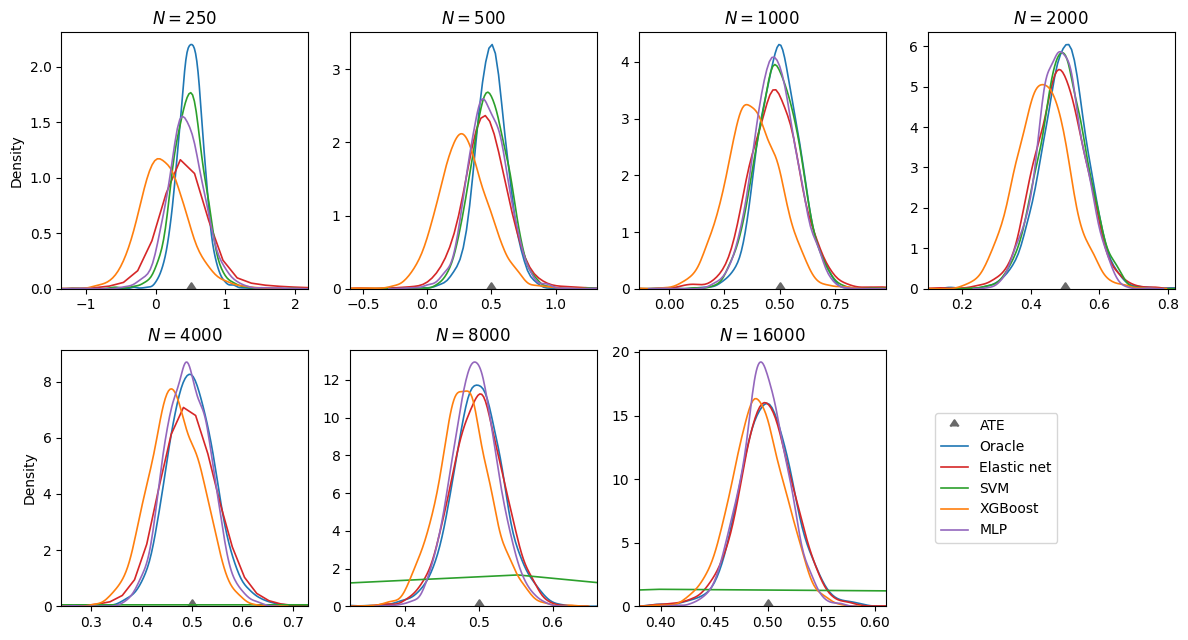

In [10]:
# Visual comparison of estimators
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, N in enumerate(sample_sizes):
    ax = axes.flat[i]
    ax.scatter(theta_0, 0, marker=10, color='dimgrey', label='ATE')
    sns.kdeplot(results_ate['eln'][N][0][:, 0], ax=ax, linewidth=1.2, color='tab:blue', label='Oracle')
    
    for ml_key, ml_name in ml_models.items():
        sns.kdeplot(results_ate[ml_key][N][0][:, 1], ax=ax, linewidth=1.2, color=color_mapper[ml_key], label=ml_name)
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('') 
    if i==0:
        ax.set_xlim(left=-1.35, right=2.18)
    elif i==1:
        ax.set_xlim(left=-0.6, right=1.32)
        ax.set_yticks([0, 1, 2, 3])
    elif i==2:
        ax.set_xlim(left=-0.135, right=0.98)
    elif i==3:
        ax.set_xlim(left=0.1, right=0.82)
    elif i==4:
        ax.set_xlim(left=0.24, right=0.73)
    elif i==5:
        ax.set_xlim(left=0.325, right=0.66)
    else:
        ax.set_xlim(left=0.38, right=0.61)
        ax.set_yticks([0, 5, 10, 15, 20])
        handles, labels = ax.get_legend_handles_labels()

axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_ate_no_clipping/Sampling_distribution.{fmt}', dpi=300, bbox_inches='tight')

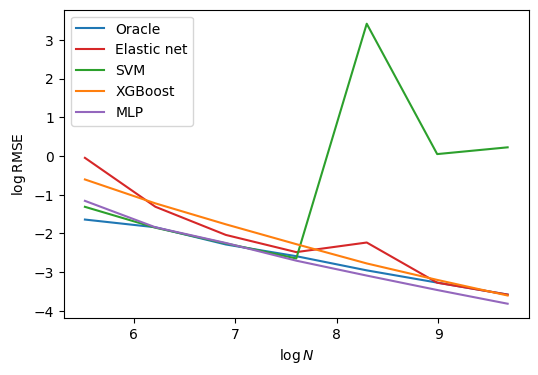

In [11]:
# Convergence rates
plt.figure(figsize=(6, 4))
rmse_list = []

rmse = [np.sqrt(np.mean((results_ate['eln'][N][0][:, 0]-theta_0)**2)) for N in sample_sizes]
rmse_list.append(rmse)
plt.plot(np.log(sample_sizes), np.log(rmse), color='tab:blue', label='Oracle')

for ml_key, ml_name in ml_models.items():
    rmse = [np.sqrt(np.mean((results_ate[ml_key][N][0][:, 1]-theta_0)**2)) for N in sample_sizes]
    rmse_list.append(rmse)
    plt.plot(np.log(sample_sizes), np.log(rmse), color=color_mapper[ml_key], label=ml_name)

plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_ate_no_clipping/Convergence_rates_1.{fmt}', dpi=300, bbox_inches='tight')

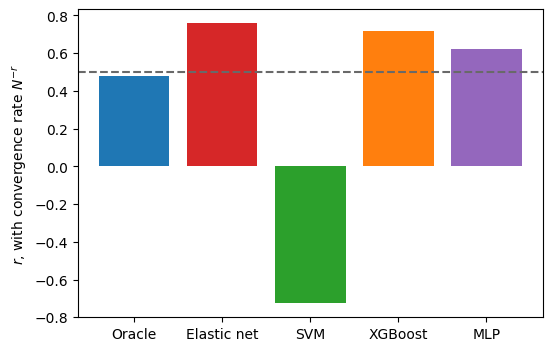

In [12]:
# Convergence rates
rmse_list = np.array(rmse_list).T
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse_list), 1)[0, :]

plt.figure(figsize=(6, 4))
plt.bar(['Oracle']+list(ml_models.values()), -slopes, color=['tab:blue']+list(color_mapper.values()))
plt.axhline(y=0.5, color='dimgrey', linestyle='--')
plt.ylabel(r'$r$, with convergence rate $N^{-r}$')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_ate_no_clipping/Convergence_rates_2.{fmt}', dpi=300, bbox_inches='tight')

In [13]:
-slopes

array([ 0.4815344 ,  0.75844191, -0.72605238,  0.71938549,  0.62131662])

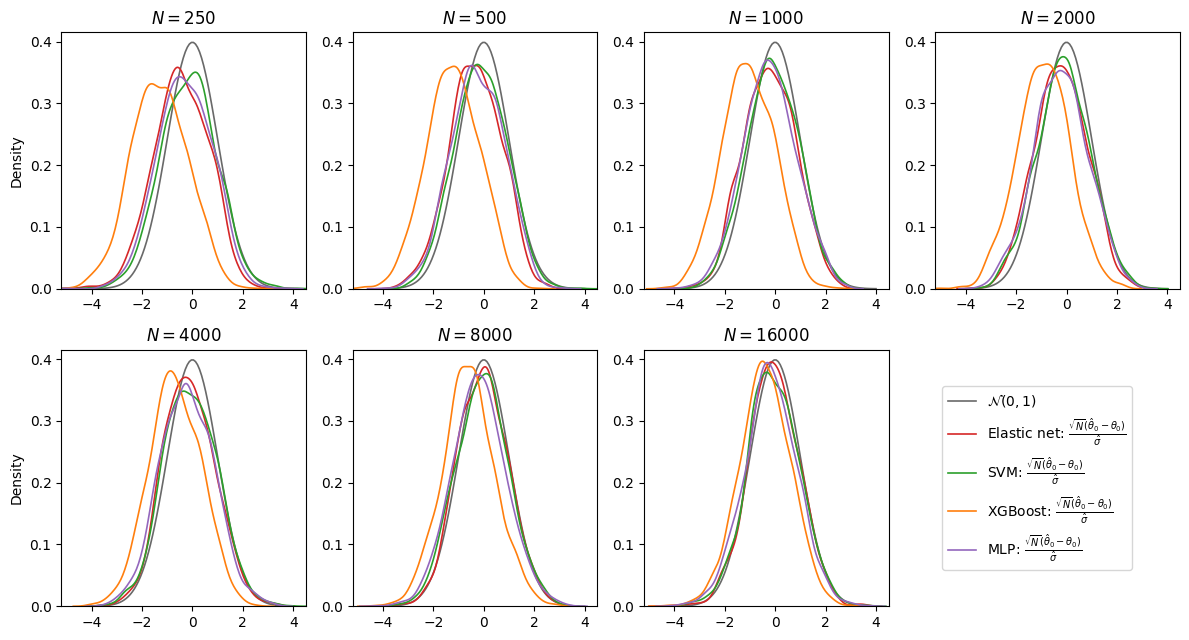

In [14]:
# Asymptotic normality
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, N in enumerate(sample_sizes):
    ax = axes.flat[i]
    ax.plot(grid, pdf_values, linewidth=1.2, color='dimgrey', label=r'$\mathcal{N}(0,1)$')
    
    for ml_key, ml_name in ml_models.items():
        ate_estimates, sigma_estimates = results_ate[ml_key][N][0][:, 1], results_ate[ml_key][N][1][:, 0]
        sns.kdeplot(np.sqrt(N)*(ate_estimates-theta_0)/sigma_estimates, 
                    ax=ax, linewidth=1.2, color=color_mapper[ml_key],
                    label=ml_name+r': $\frac{\sqrt{N}(\hat{\theta}_0-\theta_0)}{\hat{\sigma}}$')
        
    ax.set_xlim(left=-5.2, right=4.5)
    ax.set_ylim(bottom=None, top=0.415)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('') 
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()
  
axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_ate_no_clipping/Asymptotic_normality.{fmt}', dpi=300, bbox_inches='tight')

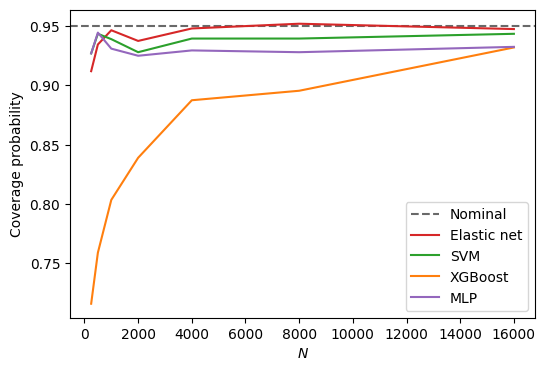

In [15]:
# Coverage probability
plt.figure(figsize=(6, 4))
plt.axhline(y=0.95, color='dimgrey', linestyle='--', label='Nominal')

for ml_key, ml_name in ml_models.items():
    CIs_list = [results_ate[ml_key][N][2][:, :2] for N in sample_sizes]
    cov_prob = [np.mean((theta_0>=CIs[:,0]) & (theta_0<=CIs[:,1])) for CIs in CIs_list]
    plt.plot(sample_sizes, cov_prob, color=color_mapper[ml_key], label=ml_name)

plt.xlabel(r'$N$')
plt.ylabel('Coverage probability')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_ate_no_clipping/Coverage_probability.{fmt}', dpi=300, bbox_inches='tight')